In [23]:
import os
import random as random
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import shutil 

In [24]:
data_dir = '/home/ec2-user/SageMaker/prediction_july4/Detected'
save_dir = '/home/ec2-user/SageMaker/prediction_july4/Detected/segmentedresults'
checkpoint_dir = '/home/ec2-user/SageMaker/OpenCV/checkpoints/checkpoint_2023-08-03_01-35-29.pt'

In [25]:
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

In [26]:
class CustomDataset(Dataset):
    def __init__(self, image_files, data_dir, transform=None):
        self.image_files = image_files
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        original_image_path = os.path.join(self.data_dir, self.image_files[index])

        if os.path.exists(original_image_path):
            image_path = original_image_path
        else:
            print(original_image_path)
            raise FileNotFoundError(f"Image not found for index {index}.")

        image = Image.open(image_path).convert("RGB")  # Convert to RGB mode

        if self.transform:
            image = self.transform(image)

        return image,original_image_path


In [27]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


In [28]:
test_dataset = CustomDataset(image_files, data_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [29]:
import torch
import torch.nn as nn

def init_conv_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class UNet(nn.Module):
    def __init__(self, input_channels=3, start_neurons=16, dropout_rate=0.0):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels, start_neurons, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(start_neurons)
        self.conv1_1 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(start_neurons)
        self.pool1 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout1 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv2 = nn.Conv2d(start_neurons, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv2_1 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.pool2 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout2 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv3 = nn.Conv2d(start_neurons * 2, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv3_1 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.pool3 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout3 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv4 = nn.Conv2d(start_neurons * 4, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv4_1 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.pool4 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout4 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Middle
        self.middle_conv1 = nn.Conv2d(start_neurons * 8, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.middle_conv1_1 = nn.Conv2d(start_neurons * 16, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.dropout_middle = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Decoder
        self.deconv4 = nn.ConvTranspose2d(start_neurons * 16, start_neurons * 8, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up4_1 = nn.Conv2d(start_neurons * 16, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv_up4_2 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_2_bn = nn.BatchNorm2d(start_neurons * 8)

        self.deconv3 = nn.ConvTranspose2d(start_neurons * 8, start_neurons * 4, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up3_1 = nn.Conv2d(start_neurons * 8, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv_up3_2 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_2_bn = nn.BatchNorm2d(start_neurons * 4)

        self.deconv2 = nn.ConvTranspose2d(start_neurons * 4, start_neurons * 2, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up2_1 = nn.Conv2d(start_neurons * 4, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv_up2_2 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_2_bn = nn.BatchNorm2d(start_neurons * 2)

        self.deconv1 = nn.ConvTranspose2d(start_neurons * 2, start_neurons, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up1_1 = nn.Conv2d(start_neurons * 2, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_1_bn = nn.BatchNorm2d(start_neurons)
        self.conv_up1_2 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_2_bn = nn.BatchNorm2d(start_neurons)

        # Output layer
        self.output_layer = nn.Conv2d(start_neurons, 1, kernel_size=1)

        # Initialize weights with identity matrices
        self.apply(init_conv_weights)

    def forward(self, x):
        # Encoder
        conv1 = nn.ReLU(inplace=True)(self.conv1_bn(self.conv1(x)))
        conv1 = nn.ReLU(inplace=True)(self.conv1_1_bn(self.conv1_1(conv1)))
        pool1 = self.pool1(conv1)
        pool1 = self.dropout1(pool1)  # Dropout added

        conv2 = nn.ReLU(inplace=True)(self.conv2_bn(self.conv2(pool1)))
        conv2 = nn.ReLU(inplace=True)(self.conv2_1_bn(self.conv2_1(conv2)))
        pool2 = self.pool2(conv2)
        pool2 = self.dropout2(pool2)  # Dropout added

        conv3 = nn.ReLU(inplace=True)(self.conv3_bn(self.conv3(pool2)))
        conv3 = nn.ReLU(inplace=True)(self.conv3_1_bn(self.conv3_1(conv3)))
        pool3 = self.pool3(conv3)
        pool3 = self.dropout3(pool3)  # Dropout added

        conv4 = nn.ReLU(inplace=True)(self.conv4_bn(self.conv4(pool3)))
        conv4 = nn.ReLU(inplace=True)(self.conv4_1_bn(self.conv4_1(conv4)))
        pool4 = self.pool4(conv4)
        pool4 = self.dropout4(pool4)  # Dropout added

        # Middle
        middle = nn.ReLU(inplace=True)(self.middle_conv1_bn(self.middle_conv1(pool4)))
        middle = nn.ReLU(inplace=True)(self.middle_conv1_1_bn(self.middle_conv1_1(middle)))
        middle = self.dropout_middle(middle)  # Dropout added

        # Decoder
        deconv4 = self.deconv4(middle)
        concat4 = torch.cat([deconv4, conv4], dim=1)
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_1_bn(self.conv_up4_1(concat4)))
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_2_bn(self.conv_up4_2(conv_up4)))

        deconv3 = self.deconv3(conv_up4)
        concat3 = torch.cat([deconv3, conv3], dim=1)
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_1_bn(self.conv_up3_1(concat3)))
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_2_bn(self.conv_up3_2(conv_up3)))

        deconv2 = self.deconv2(conv_up3)
        concat2 = torch.cat([deconv2, conv2], dim=1)
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_1_bn(self.conv_up2_1(concat2)))
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_2_bn(self.conv_up2_2(conv_up2)))

        deconv1 = self.deconv1(conv_up2)
        concat1 = torch.cat([deconv1, conv1], dim=1)
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_1_bn(self.conv_up1_1(concat1)))
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_2_bn(self.conv_up1_2(conv_up1)))

        # Output layer
        output = self.output_layer(conv_up1)

        return output


In [30]:
def process_image_with_csv(csv_file_path, image_name):
    # Read CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)

    # Extract the image names and labels from the DataFrame
    image_names = df.iloc[:, 1].apply(os.path.basename).str.strip().tolist() 
    labels = df.iloc[:, 9].tolist()

    # Values to drop (for checking against labels)
    values_to_drop = ['hydrozoa-maybe', 'copepod-maybe', 'copepod-maybe-edge', 'echinoderm-larva-maybe', 'unknown']

    # Extract the image name without directory from the provided full path
    image_name_without_directory = os.path.basename(image_name).strip() 

    # Find the corresponding label for the given image name
    if image_name_without_directory in image_names:
        index = image_names.index(image_name_without_directory)
        label = labels[index]

        # Print the image name in appropriate color
        if label in values_to_drop:
            print(f'\033[91m{image_name_without_directory}\033[0m')  # Print in red
        else:
            print(f'\033[92m{image_name_without_directory}\033[0m')  # Print in green
    else:
        print(image_name_without_directory)  # No color, print image name as-is


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

# Custom progress bar to display training progress
def custom_progress_bar(epoch, num_epochs, train_loss, val_loss):
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

def load_model(directory, model):
    checkpoint = torch.load(directory)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def test_model(model, test_loader, save_dir):
    model = load_model(checkpoint_dir, model)
    model.eval()

    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete the existing directory and its contents
    os.makedirs(save_dir)  # Recreate the directory

    with torch.no_grad():
        for images, image_name in test_loader:
            images = images.to(device)

            outputs = model(images)
            predicted_masks = (outputs > 0.5).float()  # Assuming binary segmentation
            
            for i in range(images.size(0)):
                process_image_with_csv("/home/ec2-user/SageMaker/prediction_july4/2023-07-06_Natasha.csv", image_name[i])
                plt.figure(figsize=(12, 6))
                
                plt.subplot(1, 3, 1)
                plt.title("Input Image")
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Predicted Mask")
                plt.imshow(predicted_masks[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.title("Overlay")
                
                overlay = np.copy(images[i].cpu().permute(1, 2, 0))
                overlay_mask = predicted_masks[i].cpu().squeeze() == 1

                # Define overlay color (pure red in RGB format)
                overlay_color = np.array([1.0, 0.0, 0.0])  # Red: [R, G, B]

                # Apply overlay blending
                overlay[overlay_mask] = overlay[overlay_mask] * (1 - overlay_color) + overlay_color

                plt.imshow(overlay)
                plt.axis('off')
                
                # Save the overlay image
                image_filename = os.path.basename(image_name[i])
                overlay_save_path = os.path.join(save_dir, f"{image_filename}")
                plt.savefig(overlay_save_path, bbox_inches='tight', pad_inches=0, dpi=300)
                
                plt.show()
                plt.close()

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

soloAUV 20220909-022433-006.png


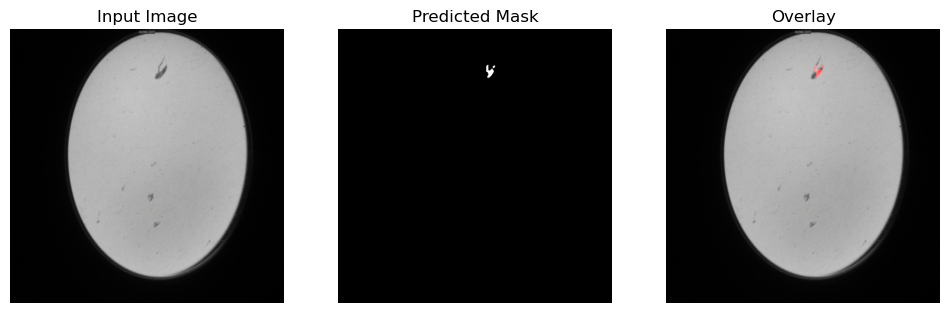

soloAUV 20220909-023105-363.png


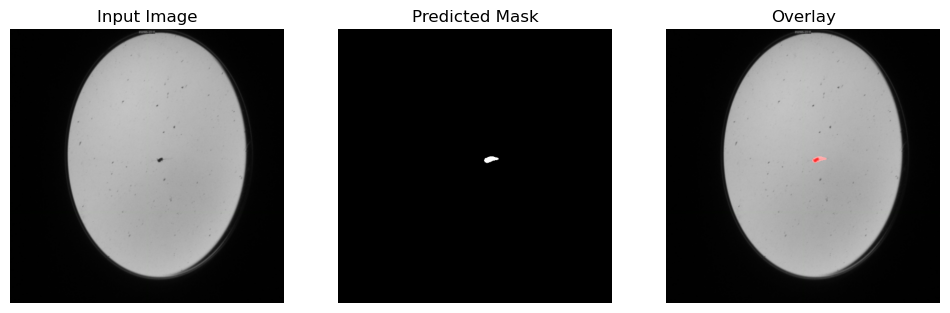

soloAUV 20220909-023250-458.png


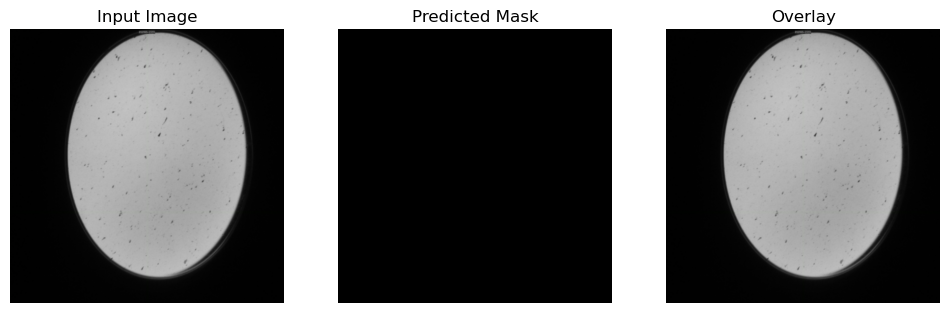

soloAUV 20220909-022514-044.png


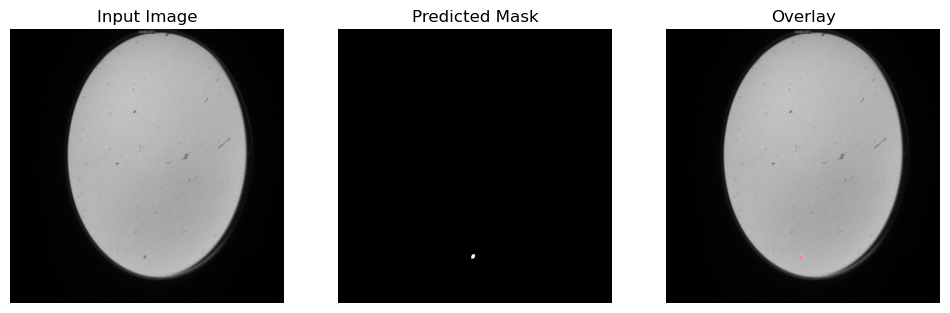

soloAUV 20220909-022602-089.png


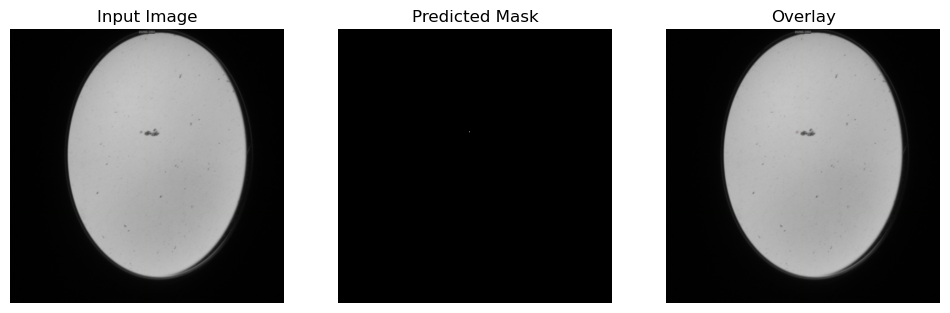

soloAUV 20220909-022508-039.png


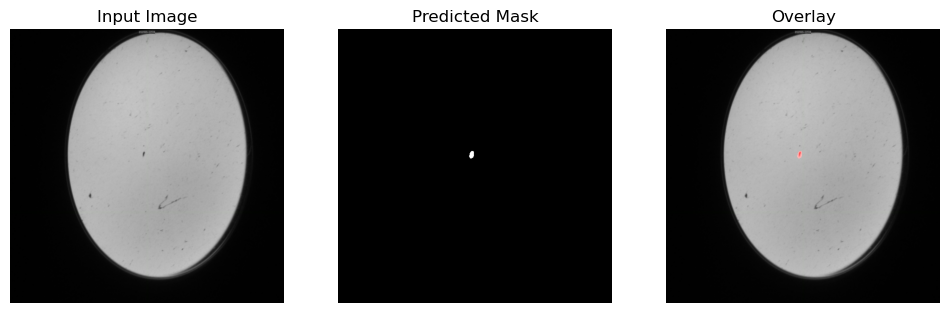

soloAUV 20220909-023021-324.png


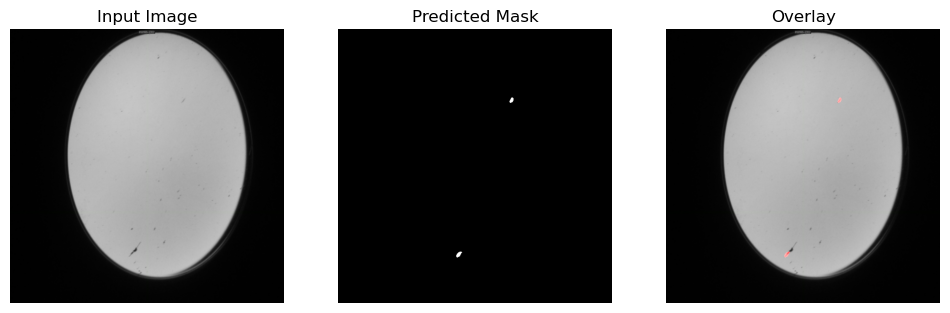

soloAUV 20220909-022550-078.png


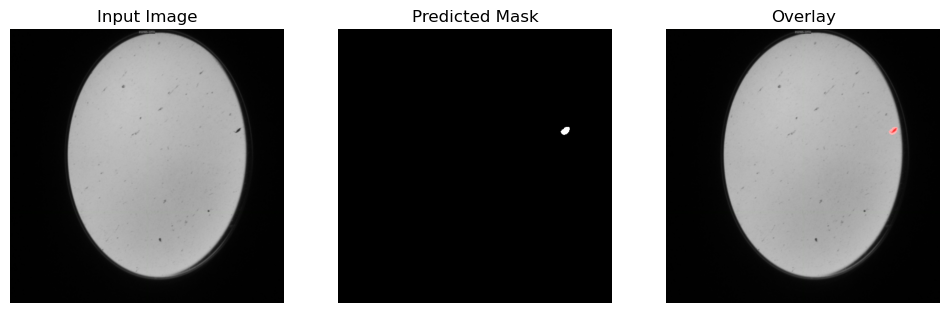

soloAUV 20220909-022553-081.png


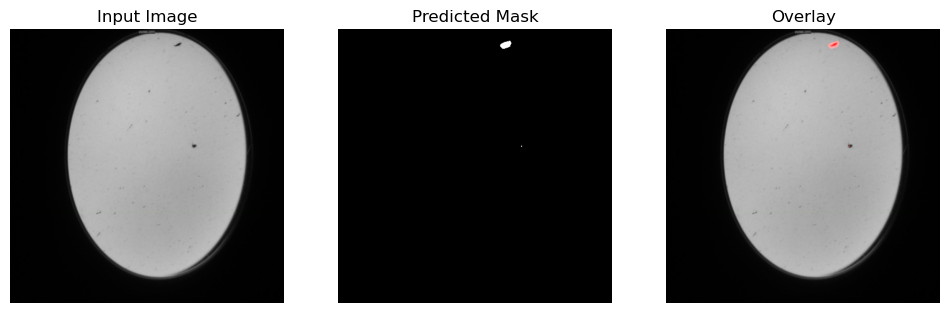

soloAUV 20220909-022638-122.png


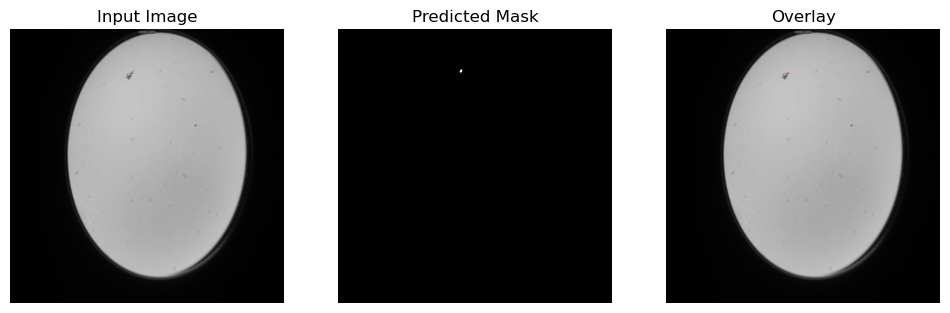

soloAUV 20220909-022753-191.png


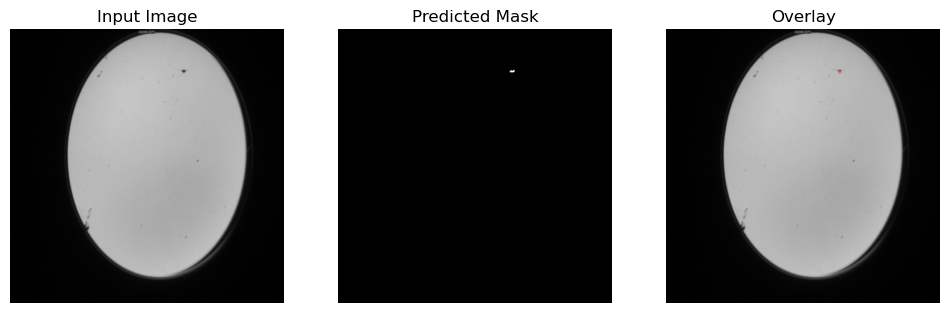

soloAUV 20220909-022525-054.png


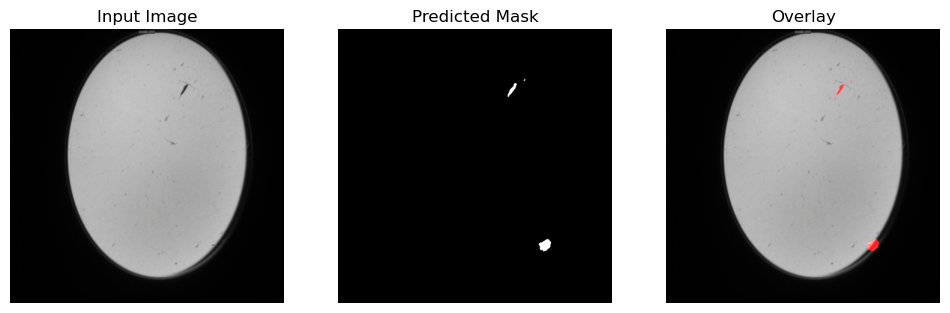

soloAUV 20220909-022629-114.png


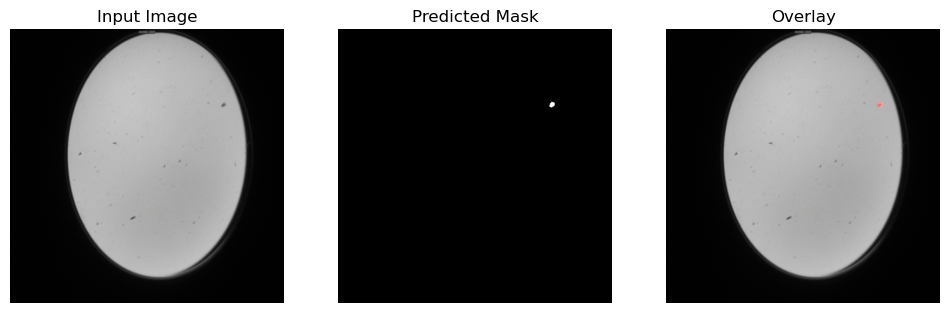

soloAUV 20220909-022519-049.png


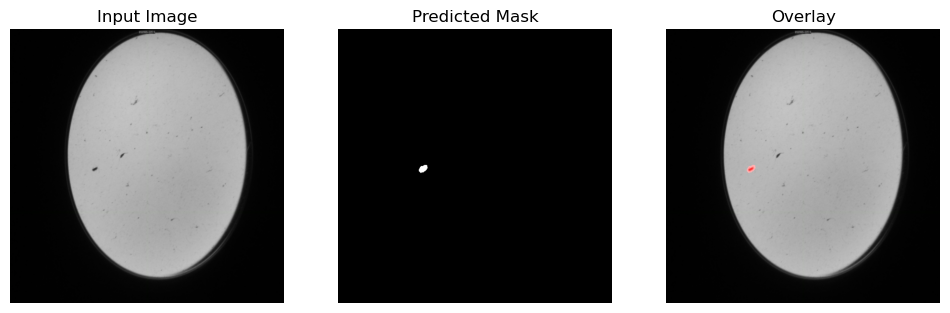

soloAUV 20220909-022658-141.png


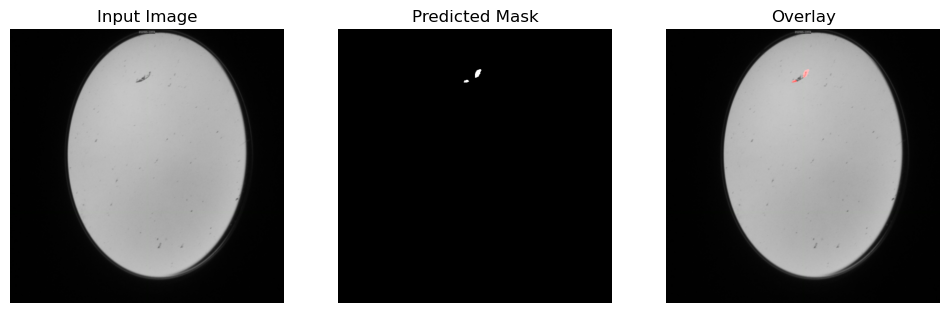

soloAUV 20220909-022449-022.png


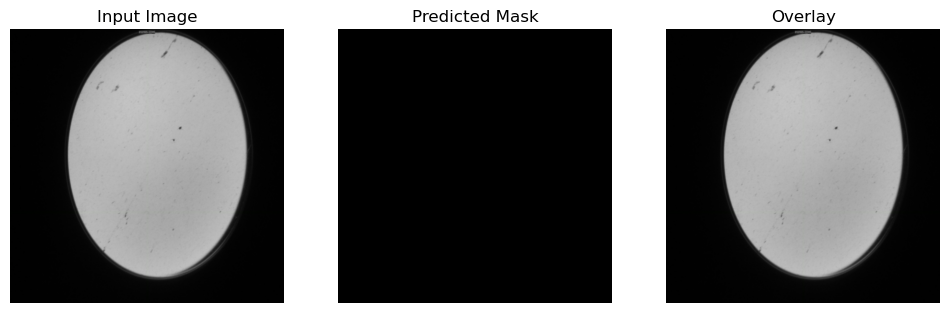

soloAUV 20220909-022601-088.png


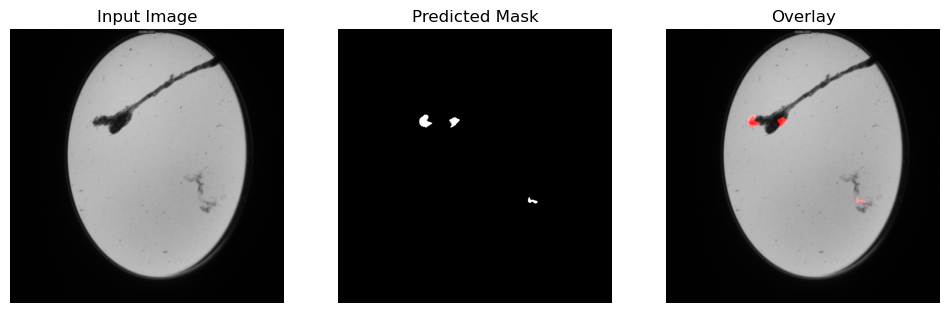

soloAUV 20220909-022611-098.png


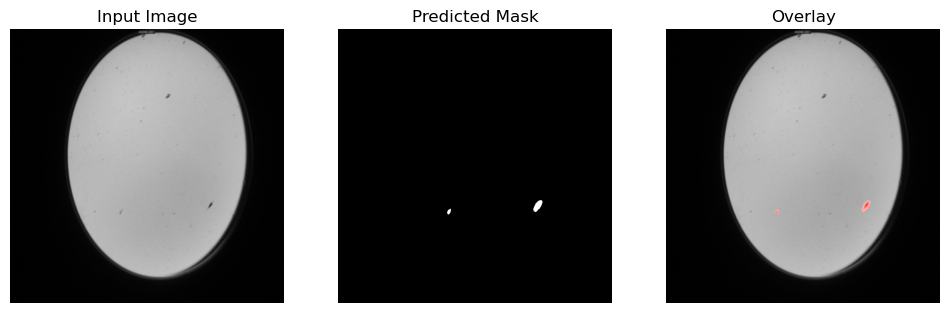

soloAUV 20220909-022521-051.png


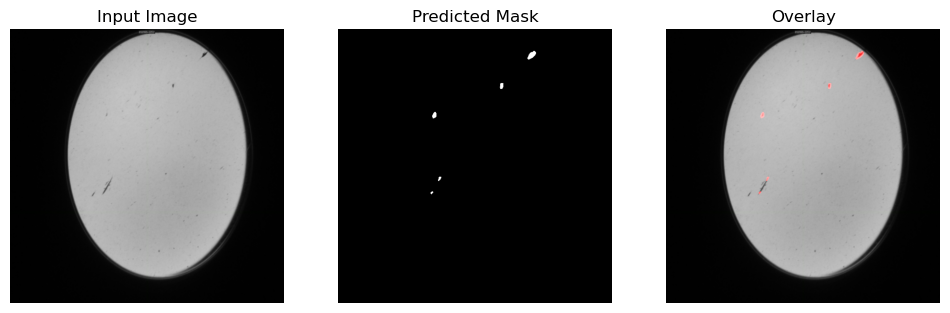

soloAUV 20220909-023202-415.png


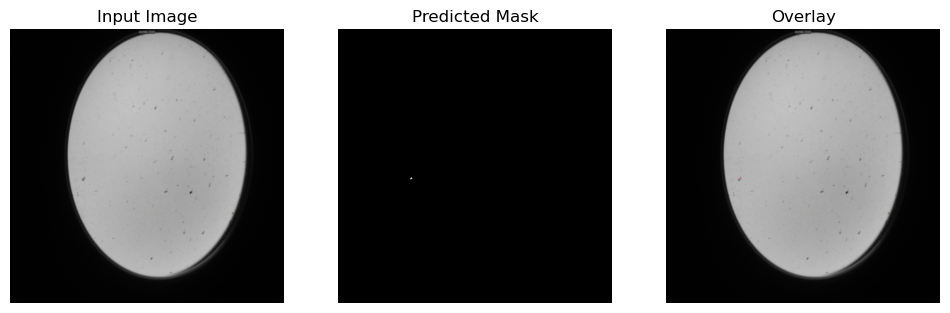

soloAUV 20220909-022452-024.png


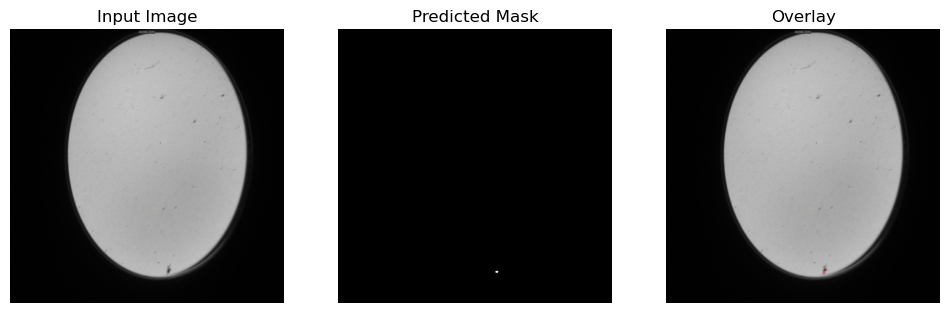

soloAUV 20220909-022453-025.png


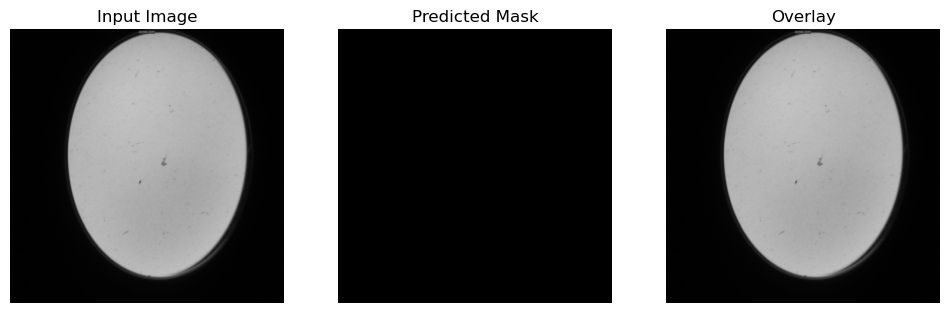

soloAUV 20220909-023328-492.png


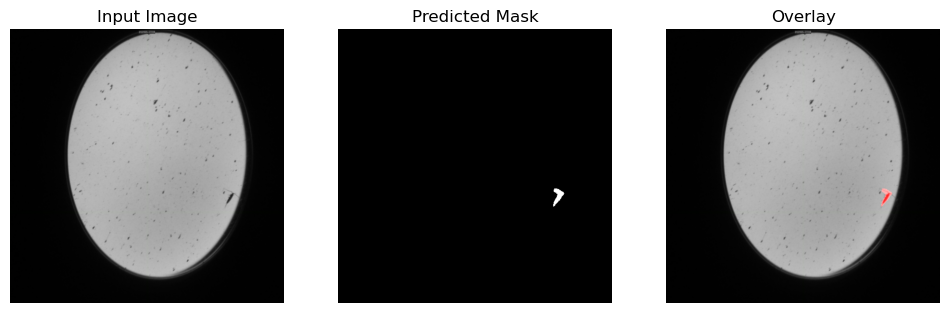

soloAUV 20220909-022510-041.png


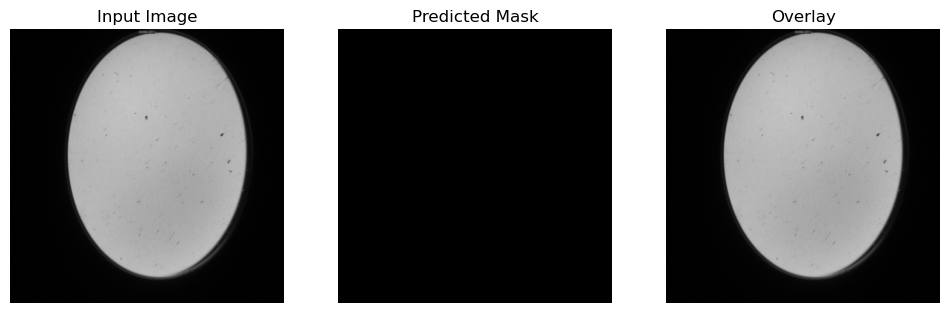

soloAUV 20220909-022630-115.png


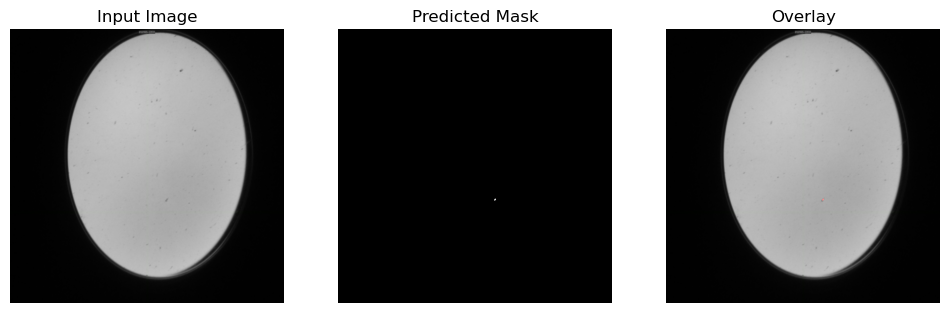

soloAUV 20220909-022432-005.png


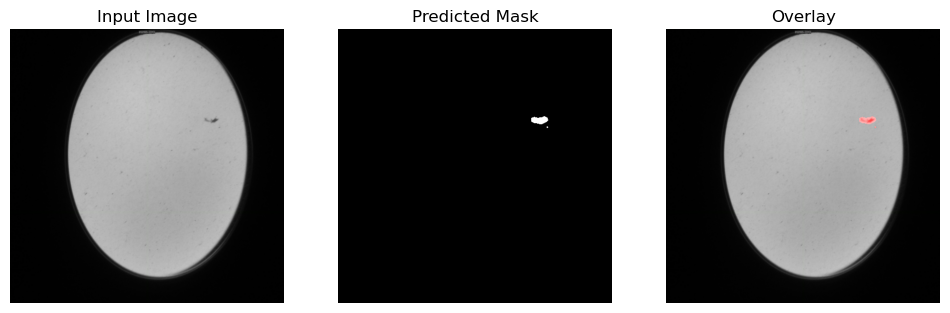

soloAUV 20220909-022504-035.png


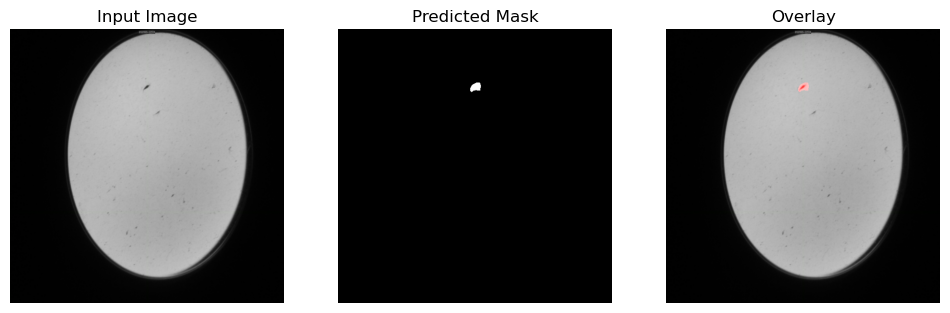

soloAUV 20220909-022549-077.png


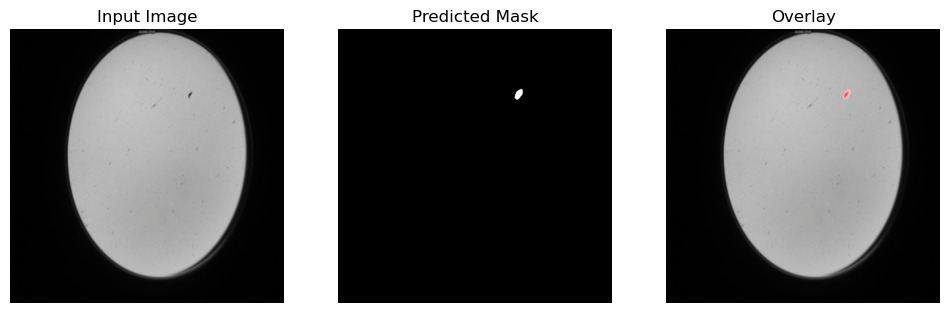

soloAUV 20220909-023226-437.png


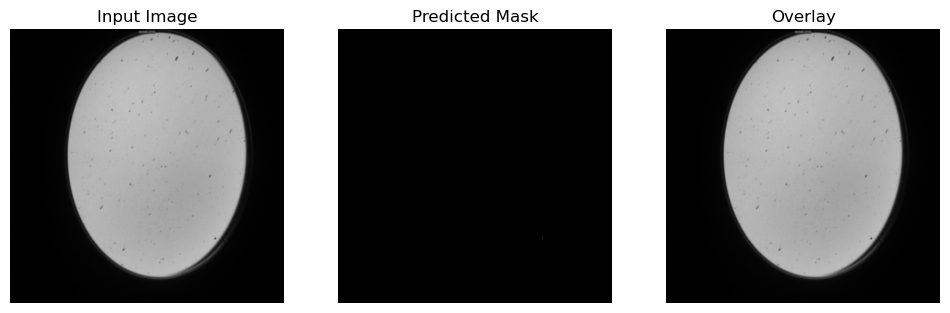

soloAUV 20220909-022436-009.png


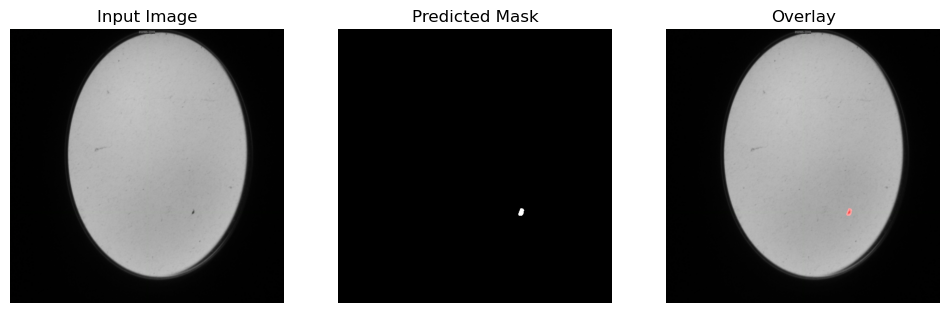

soloAUV 20220909-022625-110.png


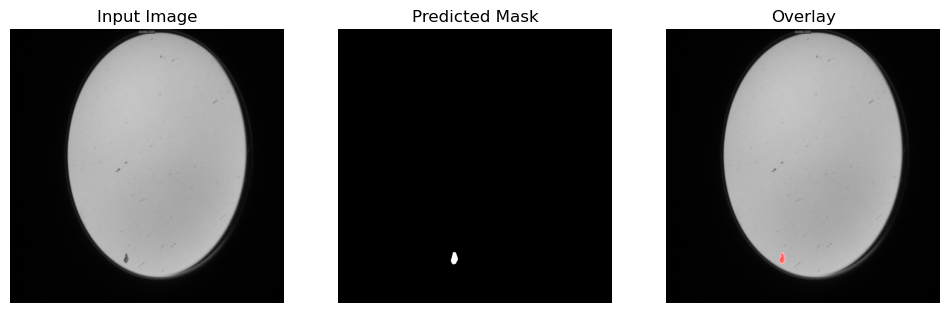

soloAUV 20220909-022437-010.png


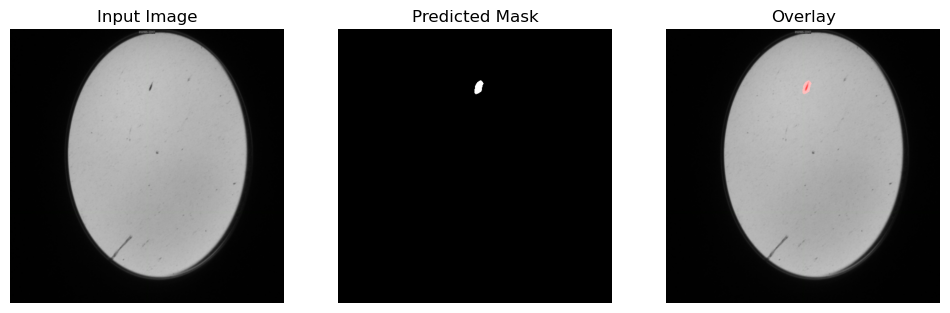

soloAUV 20220909-022529-058.png


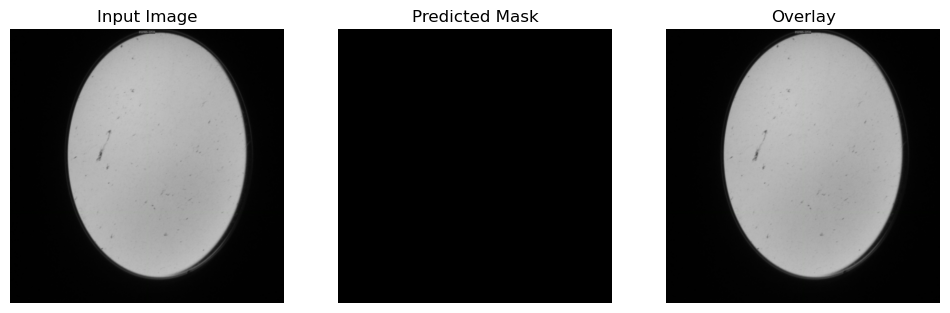

soloAUV 20220909-022459-031.png


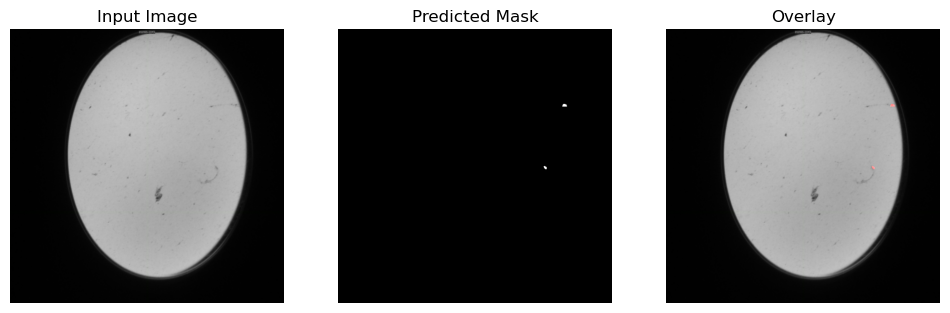

soloAUV 20220909-022505-036.png


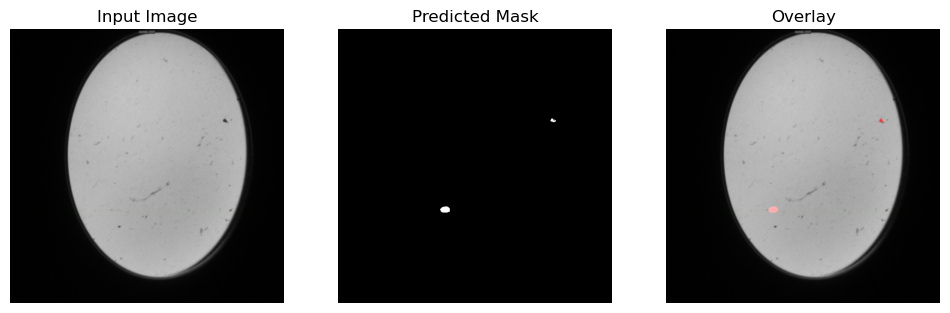

soloAUV 20220909-022623-109.png


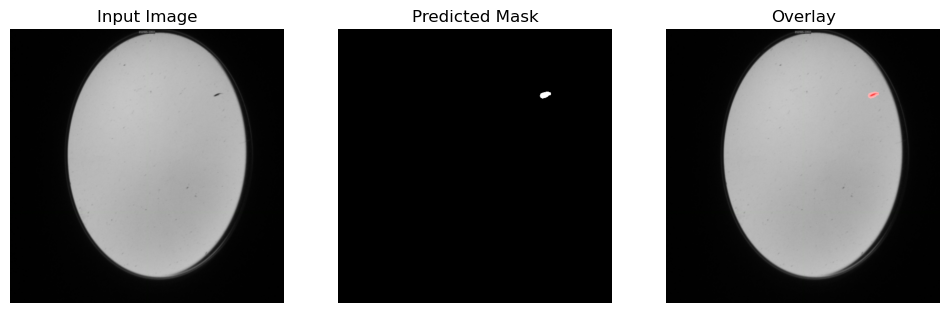

soloAUV 20220909-022840-233.png


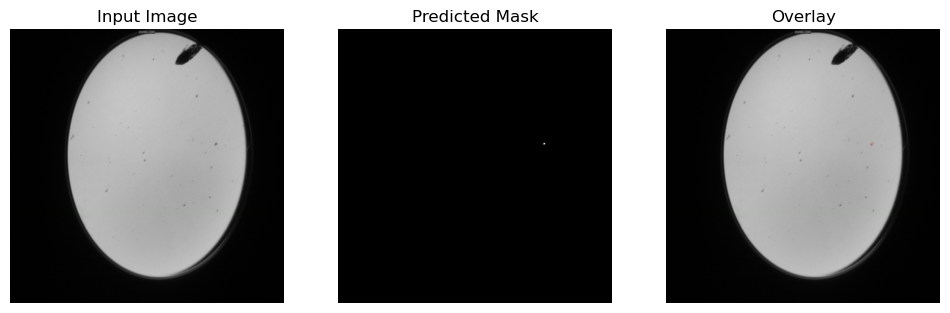

soloAUV 20220909-022839-232.png


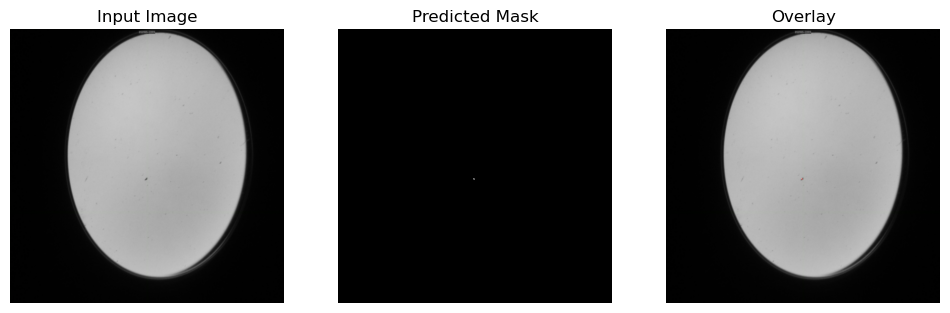

soloAUV 20220909-023322-487.png


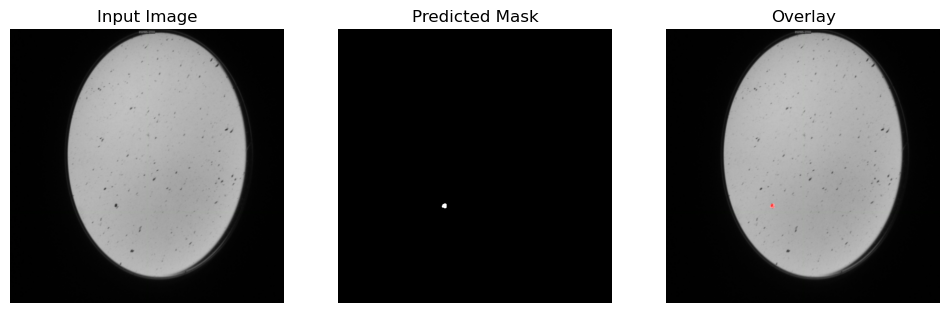

soloAUV 20220909-022506-037.png


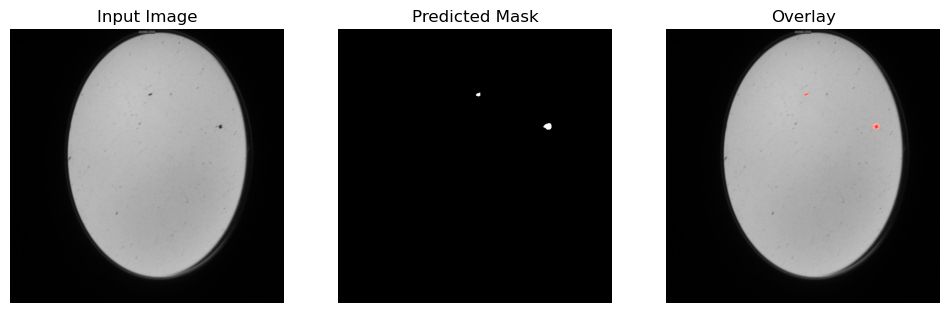

soloAUV 20220909-022935-282.png


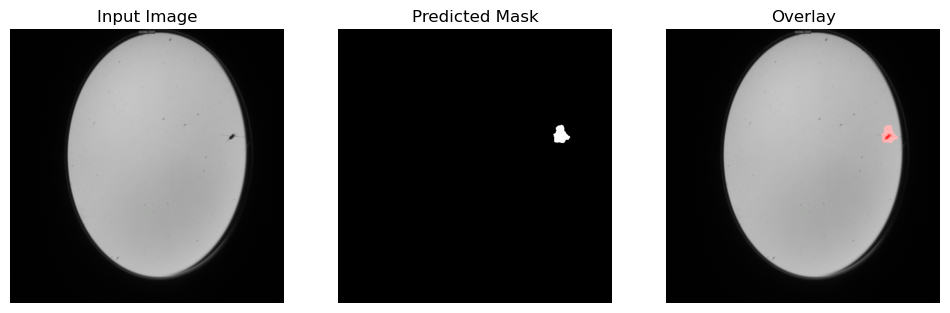

soloAUV 20220909-022544-072.png


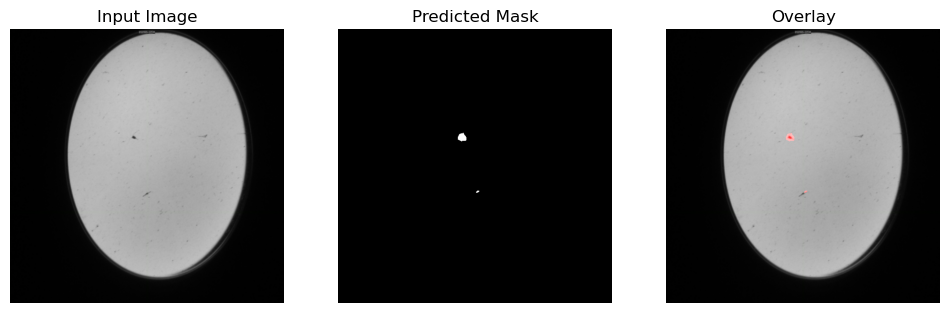

soloAUV 20220909-022608-095.png


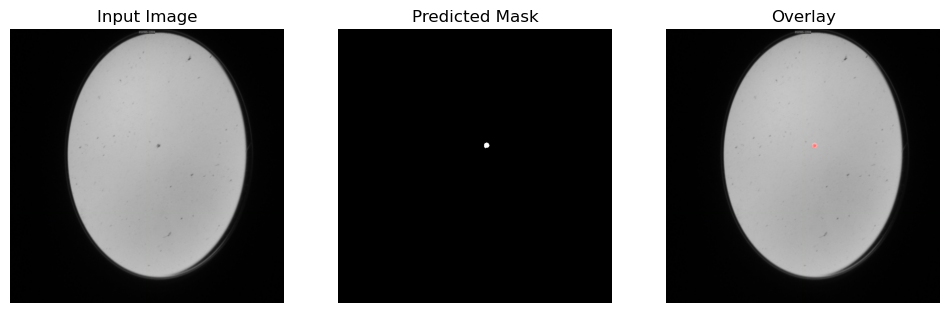

soloAUV 20220909-022555-083.png


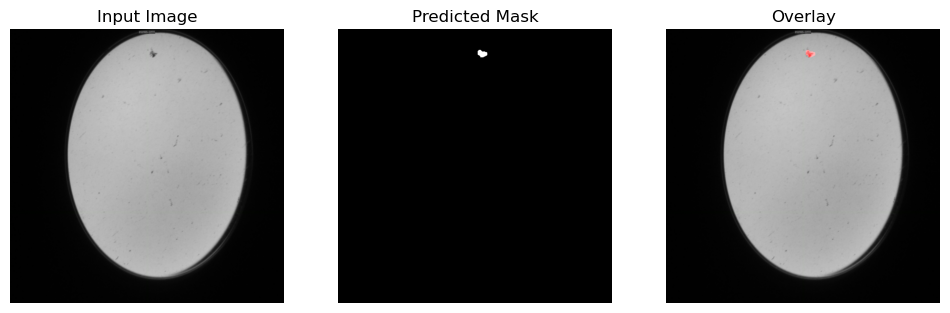

soloAUV 20220909-022853-245.png


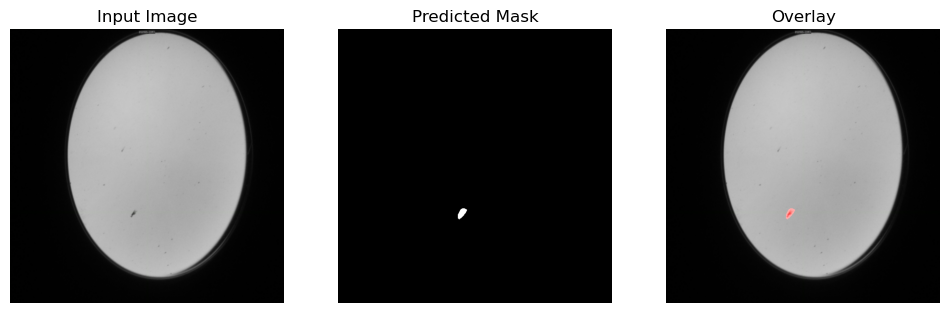

soloAUV 20220909-022648-131.png


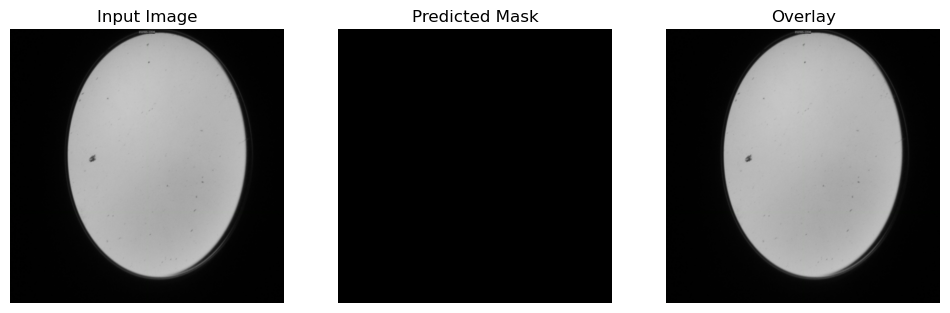

soloAUV 20220909-022503-034.png


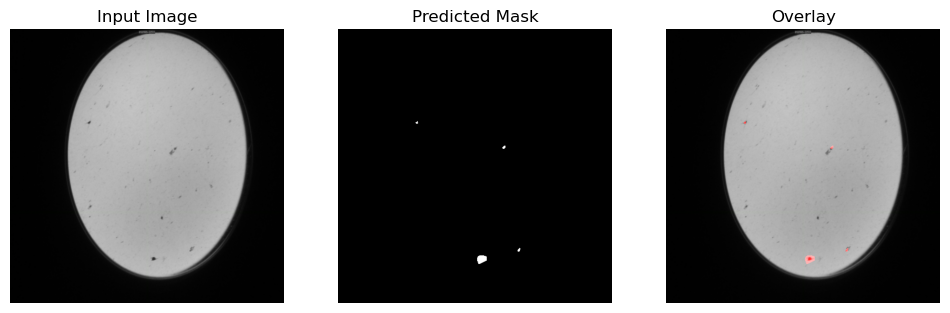

soloAUV 20220909-022551-079.png


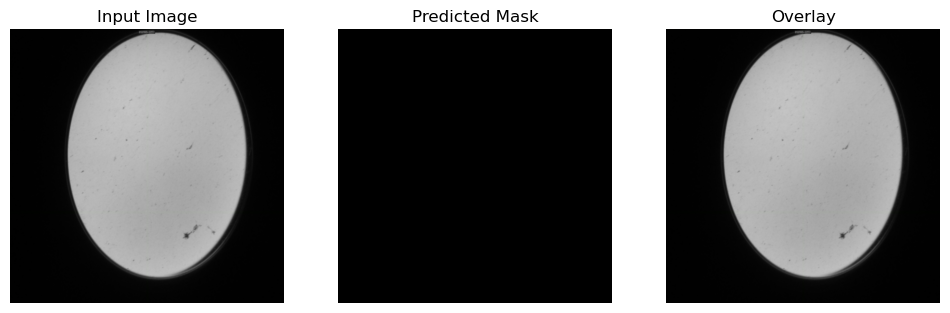

soloAUV 20220909-022923-272.png


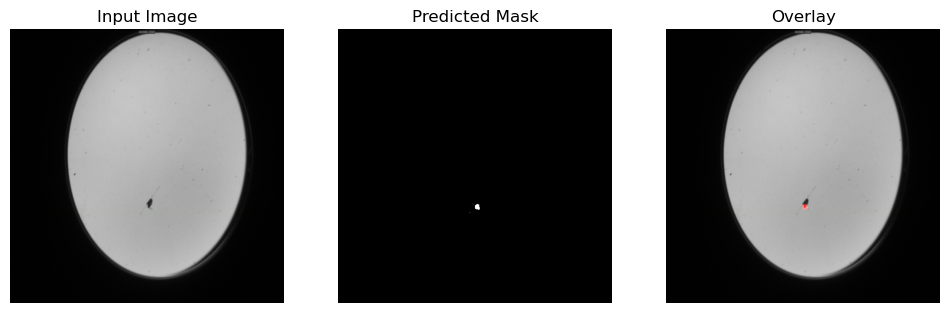

soloAUV 20220909-022936-283.png


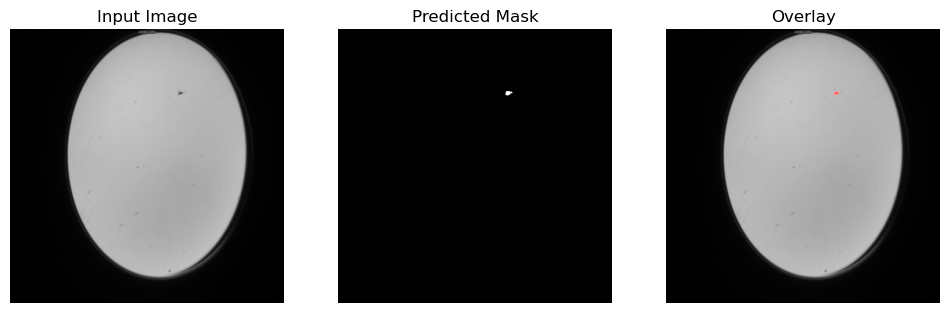

soloAUV 20220909-022556-084.png


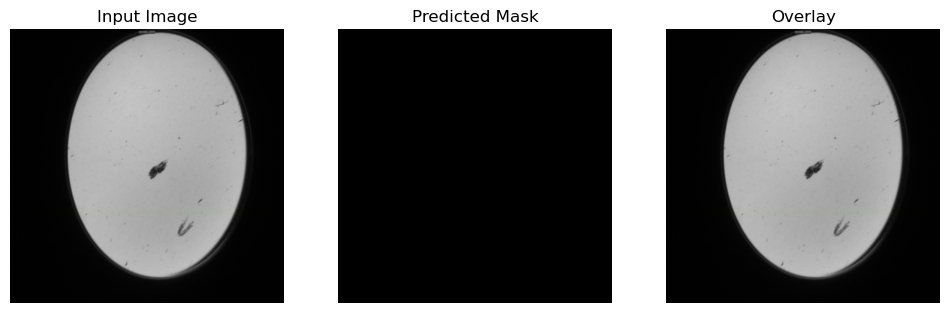

soloAUV 20220909-022547-075.png


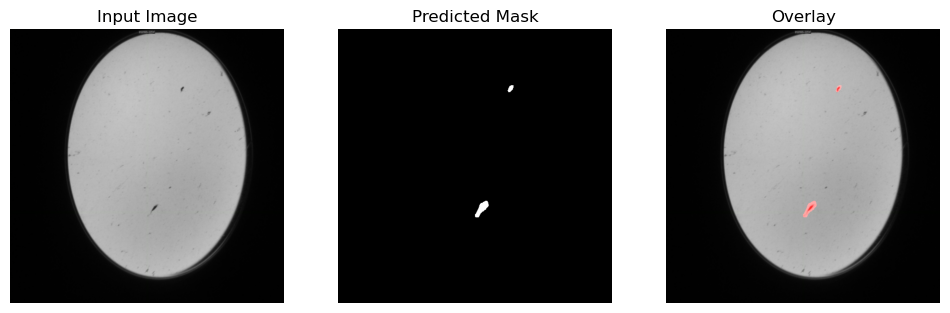

soloAUV 20220909-022605-092.png


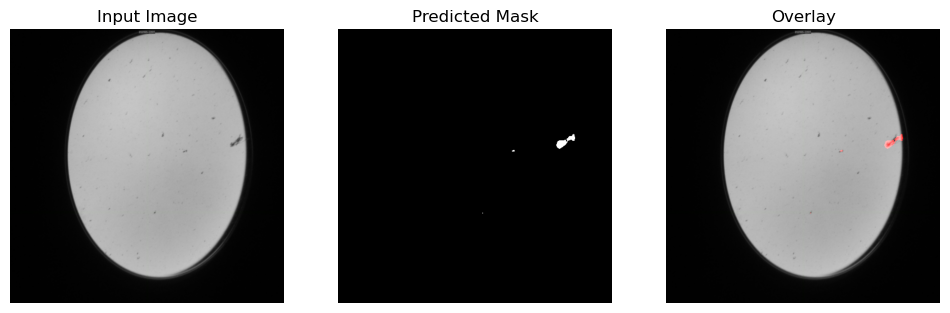

soloAUV 20220909-022932-280.png


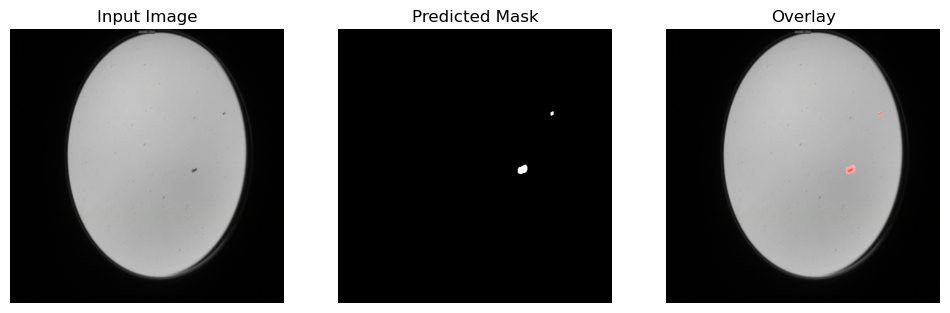

soloAUV 20220909-022516-046.png


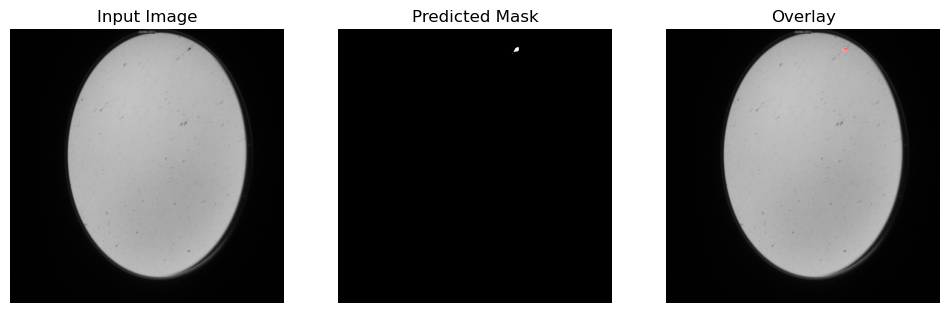

soloAUV 20220909-022458-030.png


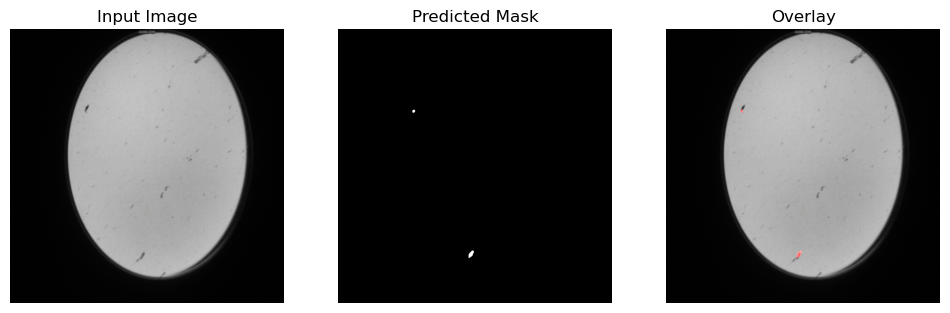

soloAUV 20220909-022540-069.png


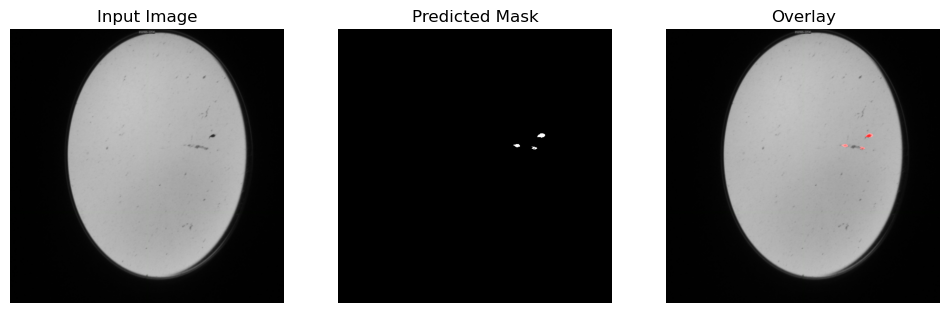

soloAUV 20220909-022435-008.png


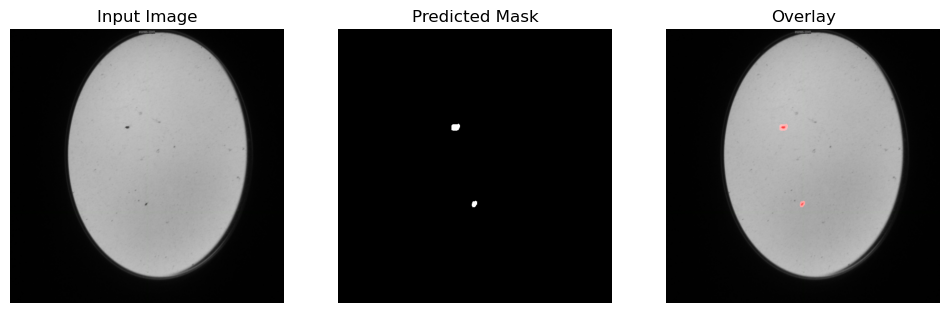

soloAUV 20220909-022842-235.png


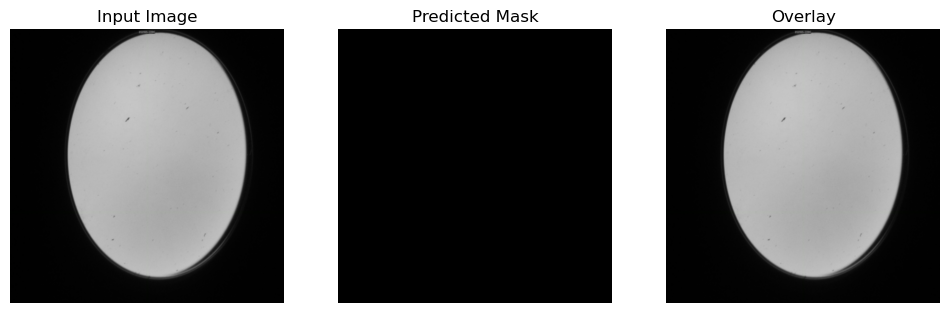

soloAUV 20220909-022829-223.png


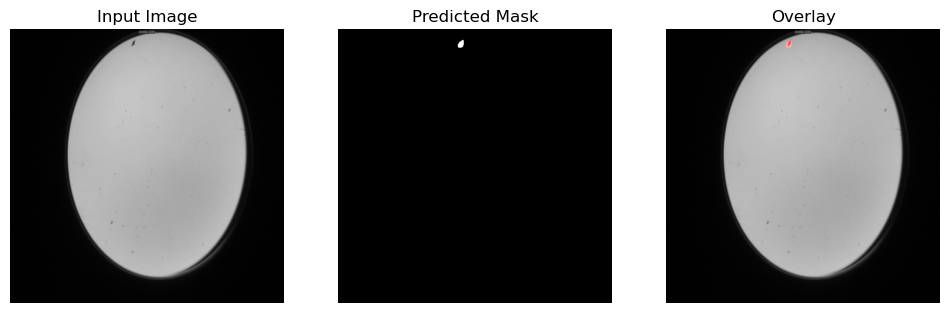

soloAUV 20220909-022706-148.png


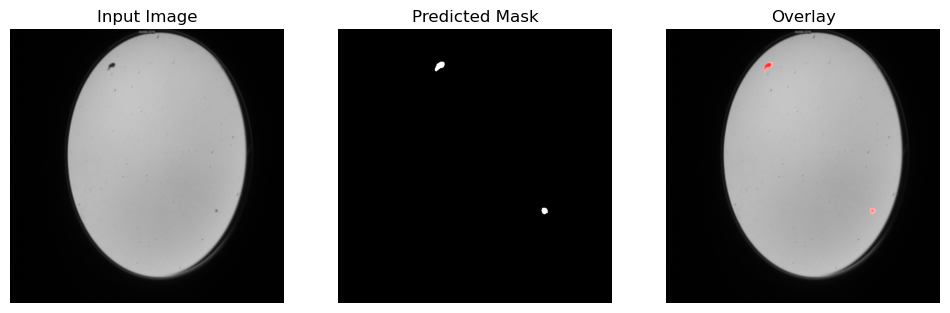

In [36]:
model = UNet(input_channels=3, start_neurons=16, dropout_rate=0.1).to(device)
test_model(model, test_loader,save_dir)